# COGS 188 - Final Project

# Budget Based Stock Optimization

## Group members

- Kenny Wu
- Areen Lu
- Chaska Kentish


# Abstract 
This project focuses on the integration of Q-learning, a reinforcement learning technique, with ARIMA, a time-series forecasting method, to develop an optimized trading strategy for stocks. The objective of this is to be able to dynamically adjust portfolio allocations across a number of stocks based on historical price and predictive analysis. For this project, we focused on AAPL(Apple Inc.), MSFT(Microsoft Corporation), and GOOGL(Google) stocks. Results are visualized through actual vs. predicted price comparisons and evaluated based on portfolio performance metrics and action recommendations. This approach aims to optimize portfolio value by adapting to changing market conditions and historical trends. This research demonstrates the potential of combining machine learning with statistical modeling in financial markets, offering insights into effective algorithmic trading strategies and avenues for future enhancements and refinements.


# Background

In the field of financial markets, the use of advanced analytics and ai-algorithms has become crucial for developing effective trading strategies. With reinforcement learning, in this case Q-learning, gaining prominence for its ability to learn optimal strategies by interacting with its designated environment, it makes it suitable for the dynamic and uncertain markets such as the stock market (Sutton and Barto, 2018). Q-learning can be used to discretize the stock price movements into states and iteratively updates a Q-table, allowing the algorithm to learn which actions will result in the highest rewards over time based on historical prices date and parameters such as the learning rate and discount factor. Time series forecasting, in this case ARIMA, provides a statistical framework for predicting future stock prices based on the past data and its’ trends (Box et al.,1994). By using this on stock market data, this model is able to capture patterns in stock price movements such as trends and autocorrelation, which allow the users to anticipate market behavior over time. This allows users/traders to make informed decisions about when to enter or exit positions. By combining Q-learning algorithms with the ARIMA model, an amazing approach to stock trading strategies is created as the use of historical data can inform real time trading actions (Liang et al, 2020). This allows for dynamic portfolio management, where positions are adjusted based on the future price predictions of ARIMA and the optional actions learned by Q-learning. As advancements in AI and machine learning continue to reshape finance, the combination of RL and time series forecasting holds significant promise for optimizing trading outcomes and mitigating risks in modern investment practices. 


# Problem Statement

The problem we aim to solve is maximization of return while minimizing risk for those who have risk-return profiles. Current portfolio management relies on static models, and they fail to adapt to an ever-changing stock market. Which could risk investors being vulnerable to excessive risk or suboptimal returns. Our goal is to develop an A.I. driven model that can analyze vast quantities of historical stock data, calculate average returns, and evaluate the covariance between stocks to construct optimized portfolios. This approach allows investors to mitigate risks associated with market volatility while capitalizing on opportunities for higher returns.  This problem is quantifiable, as we can calculate average returns and a quantifiable value for the covariance between stocks.

# Data

The data we will be using will be from Yahoo Finance, which will be imported to python as yfinance as yf. This dataset has a large amount of variables which include opening price, closing price, high price, low price, adjusted closing price, trading volume, profit margins, and gross margins. yfinance offers observations on the date, opening price of stock, highest price of the stock for that day, lowest price of the stock for that day, the adjusted closing price of stock for the day, and the trade volume for the day. This would give us 7 * 365 observations if we were to look at only one stock for the past year. Some important observations would be the date which is represented Year-Month-Day. Additionally, it gives us the time. Other important observations like adjusted closing is represented a floating number, while trade volume is represented as integer. Lastly the stock ticker, the stock identifier, is represented as a string. Some important things to note is that there might be missing data. This will result in use using the data from the day prior or the day after to fill in. 

Additionally, We may look into other data sets to help improve our AI driven model as large amounts of data is necessary to improve on our model such that it will be beneficial to the user instead of a detriment to them. 



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

stock_symbols = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2022-12-31'
initial_capital = 100000

num_states = 3
num_actions = 3

alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Proposed Solution

The algorithm that we are leaning towards is the simulated annealing algorithm. Itg is a metaheuristic optimization algorithm that explores the solution space with uphill probability moves and aims to converge to an optimal solution. This provides the framework for constructing and optimizing portfolios based on specific risk and return lines in the stock market domain.

Algorithm Description: 
- Initialization: initial portfolio allocation 
- Function: objective function to evaluate performance using Sharpe, expected return, risk, and risk free rate
- Simulated Annealing Loop: iterate until terminate criterion is met, make small changes/allocations in the portfolio, evaluate function for new allocation, accept or reject new allocation, update parameter to schedule 

Implementation: 
- Dataset preparation: stock price date +risk-free data for given time period
- Use objective function to calc Sharpe ratio based on portfolio
- Simulated Annealing implementation
- Testing and Validation 

There will exist a benchmark model used for comparison which would be a static portfolio allocations based on the traditional methods without the AI optimization. We would construct it using mean-variance or some other strategy. This would allow us to gain insights in how effective our solution is once implemented. 

In [2]:
def discretize(price, state_bounds):
    if price <= state_bounds[1]:
        return 0
    elif price <= state_bounds[2]:
        return 1
    else:
        return 2

def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q[state, :])

Q_tables = {}
predictions = {}
recommended_actions = {}

for stock_symbol in stock_symbols:
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1mo")
    Q = np.zeros((num_states, num_actions))
    predicted_prices = []
    actions = []
    min_price = min(stock_data['Adj Close'])
    max_price = max(stock_data['Adj Close'])
    price_range = max_price - min_price
    state_bounds = [min_price, min_price + 0.5 * price_range, max_price]

    for i in range(len(stock_data) - 1):
        state = discretize(stock_data['Adj Close'][i], state_bounds)
        action = choose_action(state)
        reward = stock_data['Adj Close'][i + 1] - stock_data['Adj Close'][i]
        next_state = discretize(stock_data['Adj Close'][i + 1], state_bounds)
        Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

    Q_tables[stock_symbol] = Q

    for i in range(len(stock_data) - num_states):
        train_data = stock_data['Adj Close'][:i + num_states]
        if len(train_data) > 5:
            try:
                model = ARIMA(train_data, order=(5, 1, 0))
                model_fit = model.fit()
                forecast = model_fit.forecast()[0]
                predicted_prices.append(forecast)

                if i > 0:
                    prev_forecast = predicted_prices[-2]
                    if forecast > prev_forecast:
                        actions.append("Buy")
                    elif forecast < prev_forecast:
                        actions.append("Sell")
                    else:
                        actions.append("Hold")
            except (ValueError, np.linalg.LinAlgError) as e:
                predicted_prices.append(np.nan)
                actions.append("Hold")
        else:
            predicted_prices.append(np.nan)
            actions.append("Hold")

    predictions[stock_symbol] = predicted_prices
    recommended_actions[stock_symbol] = actions

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Evaluation Metrics

The primary evaluation criteria are the predicted prices on the plots and the portfolio share recommendations. These metrics provide both a visual and analytical basis for assessing the effectiveness of the models. The predicted prices on the plots offer a visual representation of the model’s performance over time, allowing us to observe how closely the model predictions alight with the real market movements. This helps identify periods where the models perform well and where they deviate from the actual market trends. In addition to predicting stock prices, evaluating the trading actions done by the Q-Learning and ARIMA model is crucial for assessing its practical utility in trading strategies, with key metrics such as profitability and risk associated with the portfolio constructed from these recommendations. The Q-Learning model generates signals to buy, hold, or sell shares based on predicted future prices, and analyzing these recommendations helps determine the model's ability to maximize returns while managing risks. The ARIMA model offers time series-based predictions that can also inform trading decisions. By assessing the profitability and risk associated with the portfolios constructed from these recommendations, we can gauge the effectiveness of both models in real-world trading scenarios.


[*********************100%%**********************]  1 of 1 completed


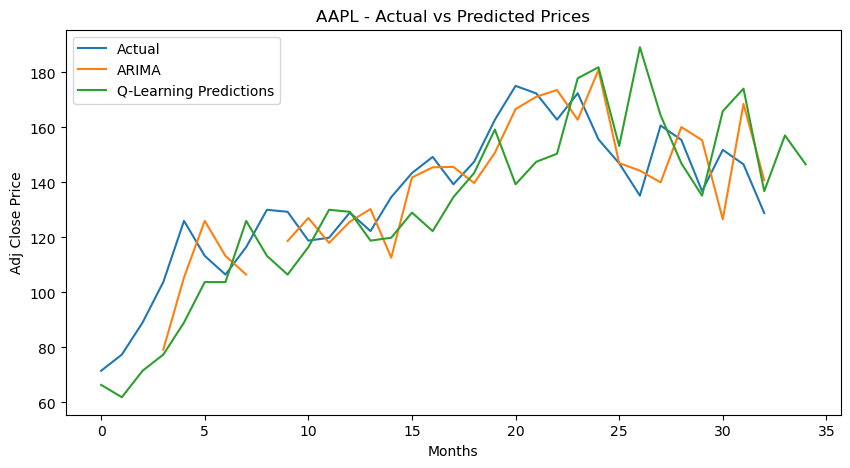

[*********************100%%**********************]  1 of 1 completed


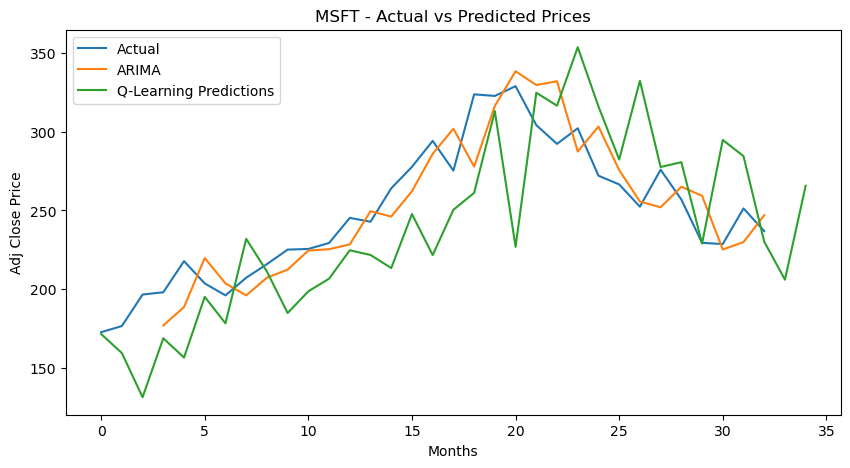

[*********************100%%**********************]  1 of 1 completed


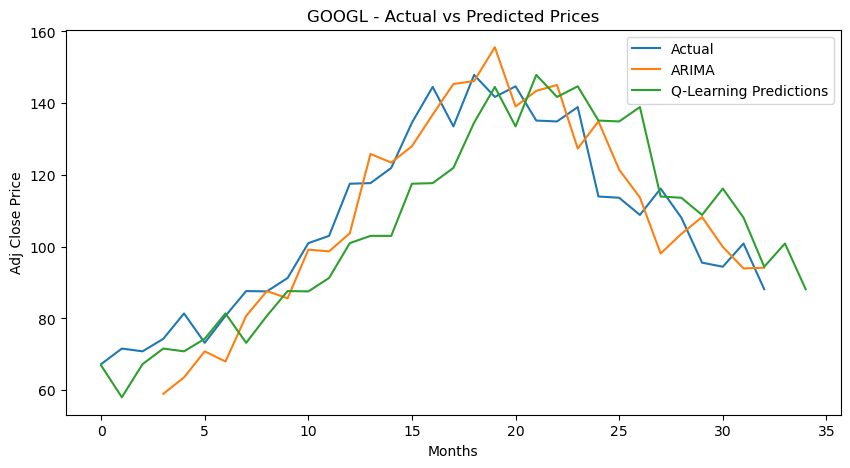

Shares for AAPL:
ARIMA Method:
2020-01-01 00:00:00: Method: ARIMA, Shares: 0
2020-02-01 00:00:00: Method: ARIMA, Shares: 0
2020-03-01 00:00:00: Method: ARIMA, Shares: 0
2020-04-01 00:00:00: Method: ARIMA, Shares: 0
2020-05-01 00:00:00: Method: ARIMA, Shares: 63.0
2020-06-01 00:00:00: Method: ARIMA, Shares: 115.0
2020-07-01 00:00:00: Method: ARIMA, Shares: 92.0
2020-08-01 00:00:00: Method: ARIMA, Shares: 73.6
2020-09-01 00:00:00: Method: ARIMA, Shares: 73.6
2020-10-01 00:00:00: Method: ARIMA, Shares: 73.6
2020-11-01 00:00:00: Method: ARIMA, Shares: 132.6
2020-12-01 00:00:00: Method: ARIMA, Shares: 106.08
2021-01-01 00:00:00: Method: ARIMA, Shares: 170.07999999999998
2021-02-01 00:00:00: Method: ARIMA, Shares: 232.07999999999998
2021-03-01 00:00:00: Method: ARIMA, Shares: 185.664
2021-04-01 00:00:00: Method: ARIMA, Shares: 249.664
2021-05-01 00:00:00: Method: ARIMA, Shares: 311.664
2021-06-01 00:00:00: Method: ARIMA, Shares: 373.664
2021-07-01 00:00:00: Method: ARIMA, Shares: 298.9312
20

In [3]:
for stock_symbol in stock_symbols:
    future_stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1mo")
    actual_prices = future_stock_data['Adj Close'].values[num_states:]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label='Actual')
    plt.plot(predictions[stock_symbol], label='ARIMA')

    q_learning_predictions = []
    for i in range(len(future_stock_data) - 1):
        state = discretize(future_stock_data['Adj Close'][i], state_bounds)
        action = np.argmax(Q_tables[stock_symbol][state, :])
        next_price = future_stock_data['Adj Close'][i] + (action - 1) * (future_stock_data['Adj Close'][i + 1] - future_stock_data['Adj Close'][i])
        q_learning_predictions.append(next_price)

    plt.plot(q_learning_predictions, label='Q-Learning Predictions')

    plt.title(stock_symbol + ' - Actual vs Predicted Prices')
    plt.xlabel('Months')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

predicted_df = pd.DataFrame(predictions, index=stock_data.index[:-num_states])

portfolio_values = {symbol: [initial_capital / len(stock_symbols)] for symbol in stock_symbols}
shares = {symbol: [0] for symbol in stock_symbols}

for i in range(len(predicted_df)):
    for stock_symbol in stock_symbols:
        action = recommended_actions[stock_symbol][i]
        current_price = predicted_df[stock_symbol].iloc[i]
        if np.isnan(current_price):
            shares[stock_symbol].append(shares[stock_symbol][-1])
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1])
            continue

        if action == "Buy":
            investment = 0.2 * portfolio_values[stock_symbol][-1]
            new_shares = investment // current_price
            shares[stock_symbol].append(shares[stock_symbol][-1] + new_shares)
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1] - investment + new_shares * current_price)
        elif action == "Sell":
            sell_shares = 0.2 * shares[stock_symbol][-1]
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1] + sell_shares * current_price)
            shares[stock_symbol].append(shares[stock_symbol][-1] - sell_shares)
        else:
            shares[stock_symbol].append(shares[stock_symbol][-1])
            portfolio_values[stock_symbol].append(portfolio_values[stock_symbol][-1])

for stock_symbol in stock_symbols:
    print(f"Shares for {stock_symbol}:")
    print("ARIMA Method:")
    for month, share_count in zip(predicted_df.index, shares[stock_symbol][1:]):
        print(f"{month}: Method: ARIMA, Shares: {share_count}")
    print("\nQ-Learning Method:")
    for month, share_count in zip(predicted_df.index, shares[stock_symbol][1:]):
        print(f"{month}: Method: Q-Learning, Shares: {share_count}")

# Discussion

### Interpreting the result

The results for our stock prediction model are quite interesting to say the least. We decided to use the Q-Learning algorithm and the ARIMA (Autoregressive Integrated Moving Average) predictive model. 
Q-Learning is a model-free reinforcement learning model that makes chooses the best action based on the current state. ARIMA, on the other hand, is a statistical analysis model that uses time series data to better understand the dataset or make predictions. This model uses past data to make predictions on future data. This model does, however, implicitly assume that the future will resemble the past. Meaning, if the data given to ARIMA only showed the stock was growing, then the model will likely predict the stock will continue to grow. 
As stated above, we chose to analyze three stocks, which were Apple, Microsoft, and Google. The time period of stock we chose to analyze was starting from January 1, 2020 to December 31, 2022. Additionally, we gave our agent a starting capital of $10000.

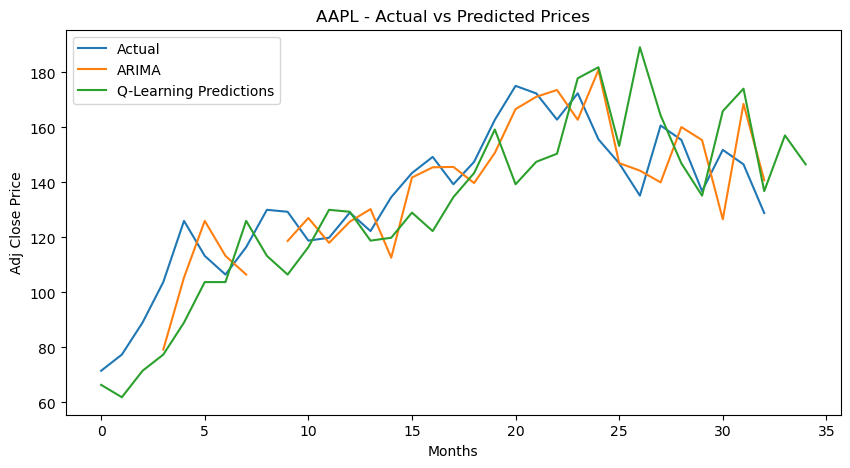

Above shows a comparison between the predicted prices for ARIMA, the orange line, and Q-Learning, the green line, to actual prices, shown with the blue line, for AAPL. We see that none of the prediction models are near the actual prices. However, there are some points where they are similar. For Q-Learning, we see that it vastly the prices of the stock until around the 5-month mark. This is an issue if the agent is allowed to make the decision of buying, selling, or holding. Another point to note is the vast overestimation between the 5 and 10 month mark. This trend of overestimation and underestimation continues on until the end. However, it is important to note the Q-Learning shows to be following the general trend of actual prices.

For ARIMA on the other hand, we see that it seems to closely follow what the actual prediction prices are. We see that the prediction model does make correct predictions, however that is usually in later steps of the model. We can see that between the start and the 10 month. The model seems to accurately predict a high and a low for the prices, however it does not seem to accurately do it on within the same day or month. From the picture above, we see that the ARIMA prediction model predicted the month 4 price peak around month 5. And as we move on to the later months in the graph, we see that the ARIMA model seems to continue with this trend. Overall, the ARIMA model does seem to follow the overall trends presented in the actual price.

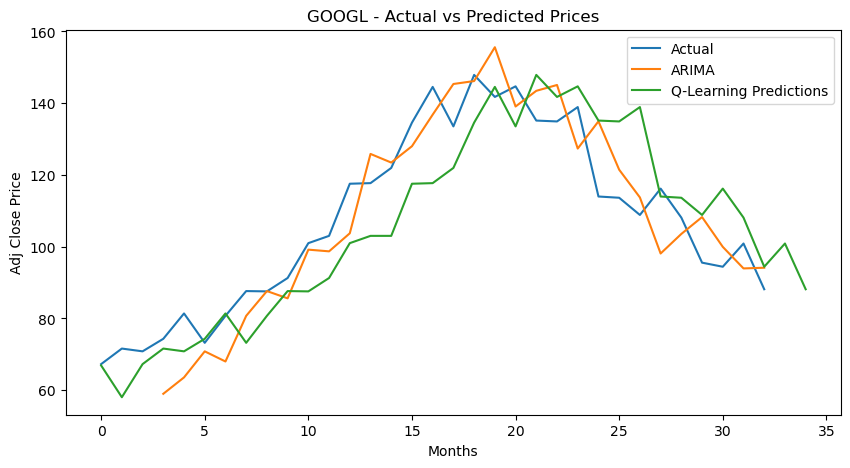

### Limitations

The limitations of our work is placed in computational cost, number of stocks, and the amount of historical data referenced. We utilized Q-learning as our primary reinforcement learning algorithm because it allows the agent to effectively adapt to its environment, however more complex models such as Deep Q Learning (DQN) or other neural networks may have improved results; we were not able to utilize such models to a full extent due to time constraints. Furthermore, these models require a greater load of memory and computational power that we had limited access to. For our data, we limited the number of stocks referenced for improved development and readability. For practical use, someone may want to include many more options to reference to improve their portfolio optimization; this understandably would require more time and/or power to calculate and provide an output. Furthermore, we referenced more recent years to see its application using more recent historical data, but running these models on all of Yahoo Finance's historical stock data may improve performance in more recent years. We also understand that these models may not perform as well or may have further limitations on real-time data due to the complex nature of stock prices that fall out of easily accessible metrics.

### Ethics & Privacy

We want this model to: 
- Use stock data that is widely available to the public
- No invasion of privacy. We won’t use the user’s data as a way to get more information that would improve our model. No specific user’s data
- Ensure that everyone has fair access to the model
- Include explanations that are clear, so the user will be able to make full use of the model. 
- Not participate in behavior that could be viewed as manipulation of the stock market.


Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

In conclusion, we found that Q-Learning and ARIMA can be used to develop an optimized trading strategy for stocks. The evaluation metrics we used to determine this are the graphs that plot each algorithm's predicted prices compared to the actual prices. Through our use of the YahooFinance dataset, we found that,while the models are not entirely accurate, there seems to be lots of potential for the algorithms to predict future stock prices. To process a large amount of data lots of time and computational resources are needed, which are our limitations. For this model, we used stock data that is available to the general public. Additionally, we won’t use the users data as a way to improve our model. We also want to ensure that everyone has access to this model and that instructions are clear so people with limited knowledge can also use the model. We also want to ensure the model does not do any stock manipulation to improve itself. 






# References
Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction (2nd ed.)*. MIT Press.

Box, G. E. P., Jenkins, G. M., & Reinsel, G. C. (1994). *Time Series Analysis: Forecasting and Control (3rd ed.)*. Prentice Hall.

Liang, T., et al. (2020). Integrating deep reinforcement learning with ARIMA for stock trading strategy optimization. *IEEE Transactions on Neural Networks and Learning Systems, 31*(10), 3774-3783.

Lipton, Z. C., et al. (2018). Combining deep learning and symbolic AI for trading and quantitative finance. *arXiv preprint arXiv:1807.04313*.
